# Neural的调度能力
限制速度幅度的情况下，同样的信息输入，同样的控制结构。
自适应的NNs总是比固定比例的控制器更好，同时damped effect更好。

Starting training...
Epoch [10/2000], Loss: 216592.6406
Epoch [20/2000], Loss: 86827.0078
Epoch [30/2000], Loss: 44056.7422
Epoch [40/2000], Loss: 33502.7656
Epoch [50/2000], Loss: 23335.1094
Epoch [60/2000], Loss: 12134.4883
Epoch [70/2000], Loss: 10994.5742
Epoch [80/2000], Loss: 10080.8145
Epoch [90/2000], Loss: 9374.8828
Epoch [100/2000], Loss: 8952.3447
Epoch [110/2000], Loss: 8569.1436
Epoch [120/2000], Loss: 8238.5791
Epoch [130/2000], Loss: 7926.4082
Epoch [140/2000], Loss: 7628.1831
Epoch [150/2000], Loss: 7340.2925
Epoch [160/2000], Loss: 7066.5923
Epoch [170/2000], Loss: 6806.8120
Epoch [180/2000], Loss: 6561.2100
Epoch [190/2000], Loss: 6327.2500
Epoch [200/2000], Loss: 6106.7598
Epoch [210/2000], Loss: 5900.8970
Epoch [220/2000], Loss: 5707.8262
Epoch [230/2000], Loss: 5525.6514
Epoch [240/2000], Loss: 5355.0254
Epoch [250/2000], Loss: 5193.6792
Epoch [260/2000], Loss: 5020.6992
Epoch [270/2000], Loss: 4880.2837
Epoch [280/2000], Loss: 4752.4385
Epoch [290/2000], Loss: 464

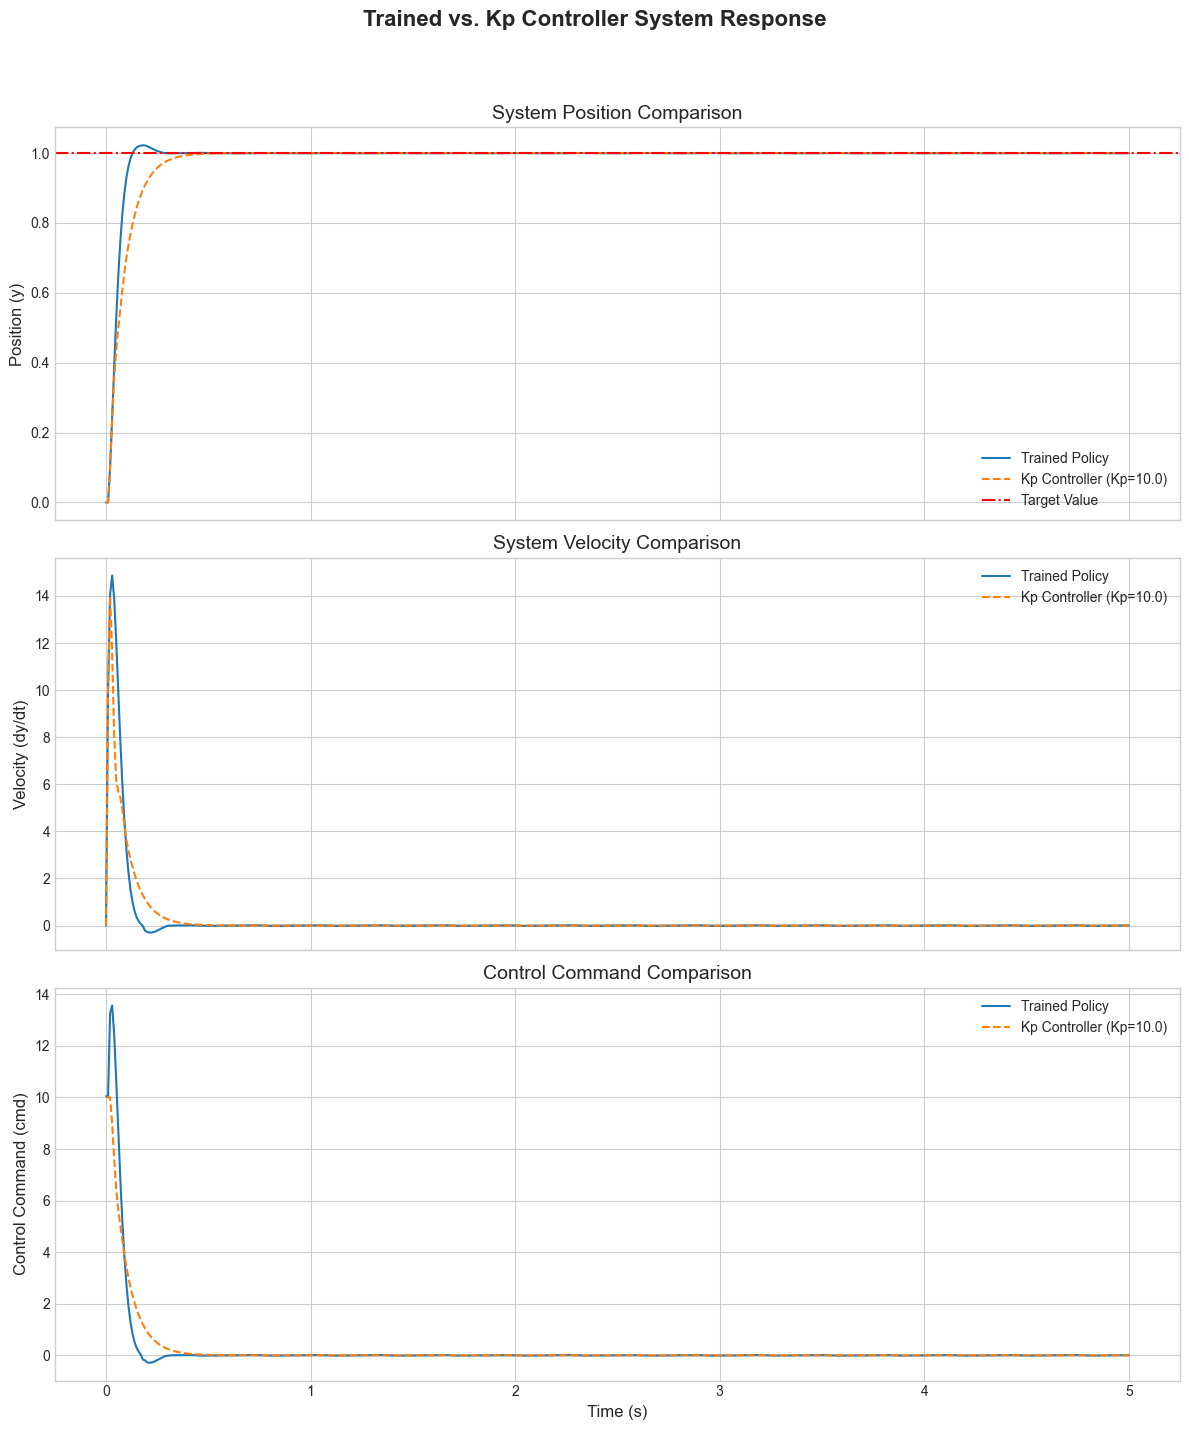

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# Define the ThirdOrderSystem as an nn.Module
class ThirdOrderSystem(nn.Module):
    def __init__(self, zeta, omega_n, sim_dt=0.01):
        super(ThirdOrderSystem, self).__init__()
        self.zeta = torch.tensor(zeta, dtype=torch.float32)
        self.omega_n = torch.tensor(omega_n, dtype=torch.float32)
        self.sim_dt = sim_dt
        self.state = torch.zeros(3)

    def simulate(self, cmd):
        angle = self.state[0]
        angle_next = angle + self.sim_dt * self.state[1]
        y, dy_dt = self.state[1], self.state[2]

        dy_dt2 = (
            -(self.omega_n**2) * y
            - 2 * self.zeta * self.omega_n * dy_dt
            + self.omega_n**2 * cmd
        )

        y_next = y + dy_dt * self.sim_dt
        dy_dt_next = dy_dt + dy_dt2 * self.sim_dt
        self.state = torch.stack([angle_next, y_next, dy_dt_next])
        return self.state


# Define the ControlPolicy as an nn.Module
class ControlPolicy(nn.Module):
    def __init__(self):
        super(ControlPolicy, self).__init__()
        self.control_net = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, target, current_state):
        error = target - current_state[0]
        velocity = current_state[1]
        # Input to the network: position error and velocity
        net_input = torch.stack([error, velocity])
        cmd = self.control_net(net_input)
        return cmd.squeeze()


# Simulation parameters
zeta_val = 0.8
omega_n_val = 100.0
dt = 0.1
target_value = torch.tensor(1.0)

# Instantiate models and optimizer
system = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val)
policy = ControlPolicy()
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)

# Training loop with BPTT
num_epochs = 2000
rho1 = 1000.0  # Weight for position error
rho2 = 100.0  # Weight for velocity squared
velocity_limit = 14.0  # Velocity limit for penalty
print("Starting training...")
for epoch in range(num_epochs):
    # Reset for each epoch
    system.state = torch.zeros(3)
    total_loss = 0

    # BPTT loop
    for i in range(200):
        # Get control command and simulate
        cmd = policy(target_value, system.state)
        system.simulate(cmd)

        # Only penalize position error in the later stage of the trajectory
        error_y = (target_value - system.state[0]) ** 2
        total_loss += rho1 * error_y

        # Penalize velocity if it exceeds the limit
        over_limit = torch.relu(torch.abs(system.state[1]) - velocity_limit)
        loss = rho2 * over_limit**2
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss.item():.4f}")

print("Training finished.")

# ---
# Simulation and Plotting after Training
# ---

print("Simulating and plotting the final response...")

# Re-instantiate the systems to start from a clean state
system_final_trained = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val)
system_final_kp = ThirdOrderSystem(zeta=zeta_val, omega_n=omega_n_val)

# Prepare lists to store data for plotting
positions_trained, positions_kp = [], []
velocities_trained, velocities_kp = [], []
commands_trained, commands_kp = [], []
time_points = []
time_step = 0.01  # Use a smaller time step for a smoother plot
total_time = 5.0

# -----------------
# Kp controller parameters
kp_gain = 10.0  # You can adjust this Kp gain for a better response
# -----------------

current_time = 0.0
while current_time <= total_time:
    with torch.no_grad():
        # 1. Trained policy
        cmd_trained = policy(target_value, system_final_trained.state)

        # 2. Kp controller
        error_kp = target_value - system_final_kp.state[0]
        cmd_kp = kp_gain * error_kp

    # Simulate the system's response for both controllers
    system_final_trained.simulate(cmd_trained)
    system_final_kp.simulate(cmd_kp)

    # Record the data for plotting
    positions_trained.append(system_final_trained.state[0].item())
    positions_kp.append(system_final_kp.state[0].item())
    velocities_trained.append(system_final_trained.state[1].item())
    velocities_kp.append(system_final_kp.state[1].item())
    commands_trained.append(cmd_trained.item())
    commands_kp.append(cmd_kp.item())
    time_points.append(current_time)

    current_time += time_step

# Plotting the results
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle(
    "Trained vs. Kp Controller System Response",
    fontsize=16,
    fontweight="bold",
)

# Subplot 1: Position
ax1.set_ylabel("Position (y)", fontsize=12)
ax1.plot(time_points, positions_trained, color="tab:blue", label="Trained Policy")
ax1.plot(
    time_points,
    positions_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)
ax1.axhline(y=target_value.item(), color="r", linestyle="-.", label="Target Value")
ax1.set_title("System Position Comparison", fontsize=14)
ax1.legend(loc="lower right")
ax1.grid(True)

# Subplot 2: Velocity
ax2.set_ylabel("Velocity (dy/dt)", fontsize=12)
ax2.plot(time_points, velocities_trained, color="tab:blue", label="Trained Policy")
ax2.plot(
    time_points,
    velocities_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)
ax2.set_title("System Velocity Comparison", fontsize=14)
ax2.legend(loc="upper right")
ax2.grid(True)

# Subplot 3: Control Command
ax3.set_xlabel("Time (s)", fontsize=12)
ax3.set_ylabel("Control Command (cmd)", fontsize=12)
ax3.plot(time_points, commands_trained, color="tab:blue", label="Trained Policy")
ax3.plot(
    time_points,
    commands_kp,
    color="tab:orange",
    linestyle="--",
    label=f"Kp Controller (Kp={kp_gain})",
)
ax3.set_title("Control Command Comparison", fontsize=14)
ax3.legend(loc="upper right")
ax3.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("third_order_system_comparison_full.png")
plt.show()